## CMF 1
Institut für Musikinformatik und Musikwissenschaft – Wintersemester 2025–26
### Woche 08 – Übungen

### Aufgabe 00.

Überlege dir eine Frage zum Inhalt der Vorlesung, z. B. über einen Punkt, der unklar geblieben ist oder über etwas, worüber du gerne mehr wissen möchtest.   

### Aufgabe 01. Chromagramme von symbolischen Musik-Darstellungen.

In Aufgabe 03 des letzten Übungsblatts hatten wir mithilfe der Python-Library *librosa* ein *Chromagramm* einer Audio-Datei erstellt.\
Das Ziel dieser Aufgabe ist es, eine Funktion zu schreiben, die Chromagramme ausgehend von symbolischen Darstellungen (z. B. MusicXML oder MIDI) erstellt.

In [1]:
import librosa
import music21 as m21
import numpy as np
import matplotlib.pyplot as plt

1) Zur Erinnerung: Chrogramme von Audio-Dateien können mithilfe von *librosa* mit der Funktiom *librosa.feature.chroma_stft* erstellt werden:

In [2]:
my_audio_file = "C_major_scale.wav"
y, sr = librosa.load(my_audio_file)

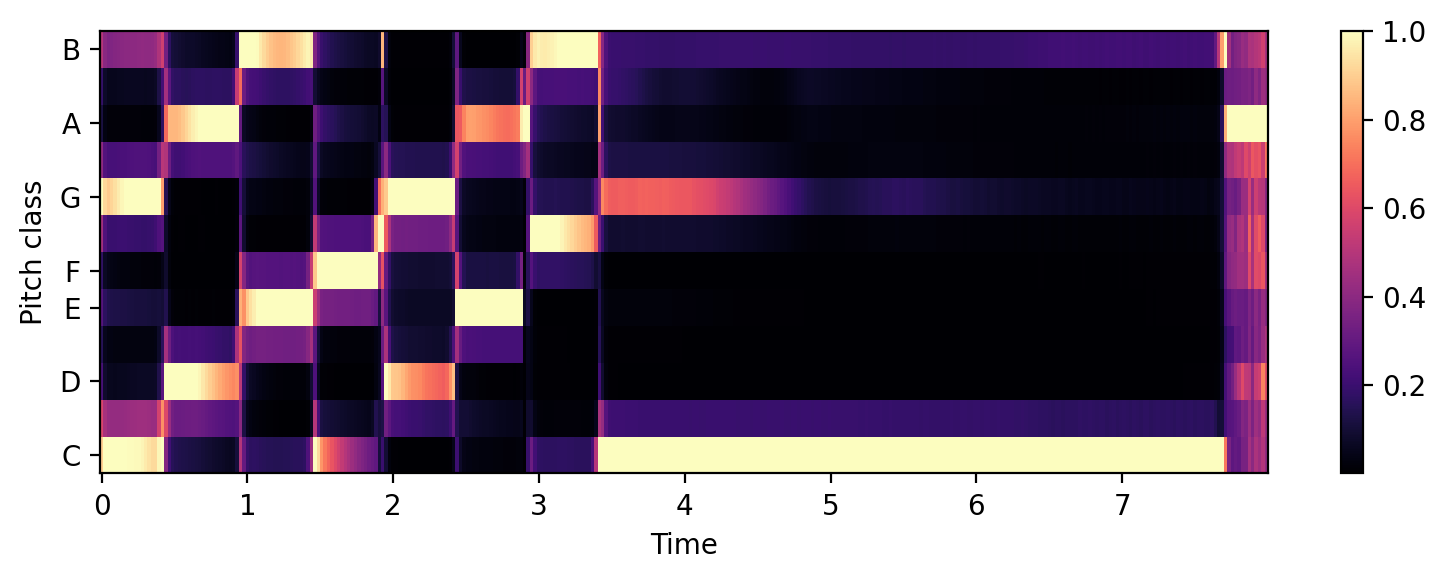

In [3]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)

plt.figure(figsize=(8, 3))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()
plt.show()

2) Greife die Grundidee eines Chromagramms auf und überlege dir eine Funktion, die Chromagramme von symbolischen Darstellungen erstellen kann.\
Zur Erinnerung: Ein Chromagramm soll aus aufeinanderfolgenden Frames bestehen, die eine konstante Dauer haben.\
Jedes dieser Frames soll die Tonhöhenklassen/Pitch-Classes enthalten, die für die Dauer des Frames im zu analysierenden Musikstück aktiv sind.\
Die Dauer eines Frames kann zum Beispiel auf einen Bruchteil einer Viertelnote (in *music21*: *quarterLength*) festgelegt werden.

In [102]:
def symbolic_chromagram(score, frames_per_quarter_note):

    chordified_score = score.chordify()
    # Akkord-Liste des zu analysierenden Scores
    score_chords = list(chordified_score.flatten().getElementsByClass(m21.chord.Chord))

    # Dauer des zu analysierenden Scores (in Viertelnoten ausgedrückt)
    total_duration = int(score_chords[-1].offset + score_chords[-1].quarterLength)

    # Anzahl der Analyse-Frames im Chromagramm
    number_frames_in_chromagram = total_duration*frames_per_quarter_note

    # Initialisierung des Chromagramms als 2-dimensionales Array, das nur Nullen enthält
    chromagram = np.zeros((12, number_frames_in_chromagram))
    # Iterierung über alle Akkorde in der Akkord-Liste
    for chord in score_chords:
        framesStart = int(chord.offset*frames_per_quarter_note)
        framesEnd = int(chord.quarterLength * frames_per_quarter_note + framesStart )
        pitches = chord.pitchClasses
        for timeIndex in np.arange(framesStart, framesEnd):
            for pitch in pitches:
                chromagram[pitch, timeIndex] += 1
                
    
    return chromagram

3) Teste die Funktion z. B. mit der Datei *Stille-Nacht.mxl* und plotte das erstellte Chromagramm.

In [96]:
score = m21.converter.parse("Stille-Nacht.mxl")

In [103]:
chromagram = symbolic_chromagram(score, 12)
print(chromagram)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [104]:
def plot_chromagram(chromagram):

    plt.figure(figsize=(10, 4))
    plt.imshow(chromagram, aspect='auto', origin='lower', interpolation='none')

    plt.yticks(np.arange(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.xlabel("Time Frames")
    plt.ylabel("Pitch Classes")
    plt.title("Chromagram")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

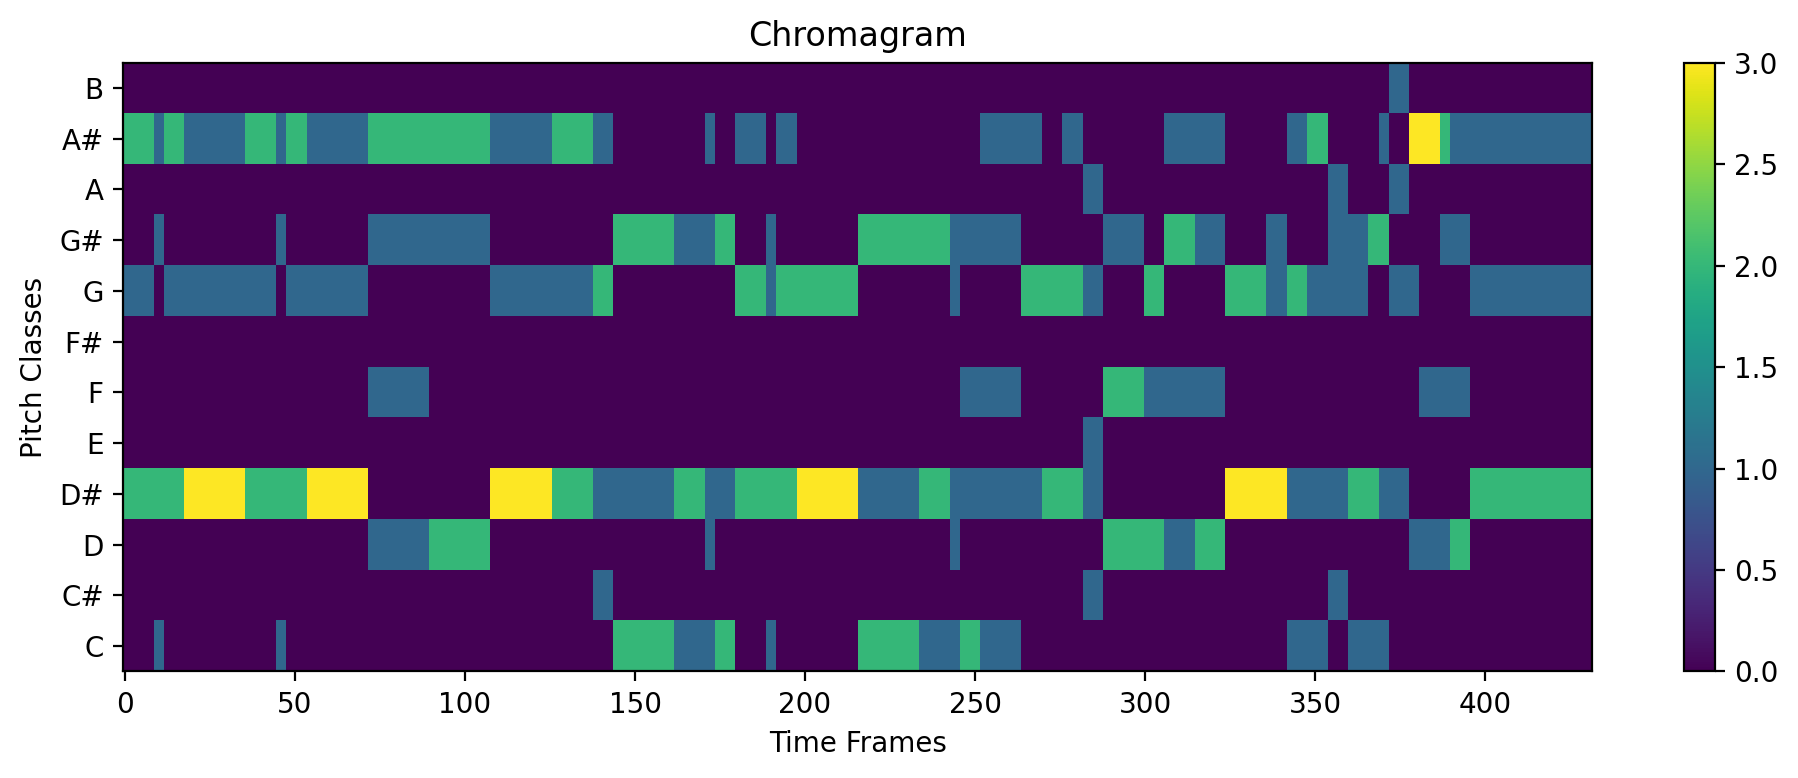

In [105]:
plot_chromagram(chromagram)

### Aufgabe 2. Eine *Dynamic-Time-Warping*-Implementierung für Akkord-Listen

In der Vorlesung haben wir eine Implementierung des *Dynamic-Time-Warpings* mithilfe der Library *librosa* gesehen.\
Das Ziel dieser Aufgabe ist es, diese so zu verändern, dass sie auf Akkord-Listen angewandt werden kann.

In [106]:
import librosa
import music21 as m21
import numpy as np
import matplotlib.pyplot as plt

1) Die folgende Funktion berechnet die *Jaccard-Similarity* (oder den *Jaccard-Index*) zwischen den 2 Akkorden.\
Da die *librosa*-Implementierung des *Dynamic-Time-Warpings* allerdings eine auf einem *Distanzmaß* beruhende *Cost-Matrix* erfordert, ist es nützlich, die *Jaccard-Similarity* in eine *Jaccard-Distance* umzuwandeln.\
Überlege dir eine Funktion, die dies tut.

In [107]:
def jaccard_similarity_for_chords(chord1, chord2):
    
    chord1_as_set = set(chord1.pitches)
    chord2_as_set = set(chord2.pitches)
    
    len_intersection = len(chord1_as_set.intersection(chord2_as_set))
    len_union = len(chord1_as_set.union(chord2_as_set))
    
    jaccard_similarity = len_intersection / len_union

    return jaccard_similarity

In [111]:
def jaccard_distance_for_chords(chord1, chord2):
    jaccardDistance = 1 - jaccard_similarity_for_chords(chord1,chord2)

    return jaccardDistance

In [112]:
chord1 = m21.chord.Chord(['C3', 'C4', 'E4', 'G4'])
chord2 = m21.chord.Chord(['C3', 'E4', 'G4'])

In [113]:
jaccard_distance_for_chords(chord1, chord2)

0.25

2) Nutze die *jaccard_distance_for_chords* für die Erstellung der *Cost-Matrix*.\
Nutze dann – wie in der Vorlesung – die *librosa*-Funktion *librosa.sequence.dtw* zur Berechnung eines *Warping-Pfads* zwischen den Akkord-Listen *chord_list1* und *chord_list2*.

In [141]:
def cost_matrix(chord_list1, chord_list2):
    lenList1 = len(chord_list1)
    lenList2 = len(chord_list2)
    matrix = np.zeros((lenList1,lenList2))
    for i in range(lenList1):
        for j in range(lenList2):
            matrix[i,j] = jaccard_distance_for_chords(chord_list1[i], chord_list2[j])
    return matrix

In [125]:
chord_list1 = [m21.chord.Chord(['C3', 'C4', 'E4', 'G4']),
               m21.chord.Chord(['C3', 'C4', 'E4', 'G4']),
               m21.chord.Chord(['G3', 'B3', 'F4']),
               m21.chord.Chord(['G3', 'B3', 'D4']),
               m21.chord.Chord(['G3', 'B3', 'F4']),
               m21.chord.Chord(['A3', 'C4', 'E4']),
               m21.chord.Chord(['A3', 'C4', 'E4', 'A4']),
               m21.chord.Chord(['F3', 'A3', 'C4', 'A4'])]

In [126]:
chord_list2 = [m21.chord.Chord(['C3', 'E4', 'G4']),
               m21.chord.Chord(['C3', 'E4', 'G4']),
               m21.chord.Chord(['C3', 'E4', 'G4']),
               m21.chord.Chord(['G3', 'B3', 'D3']),
               m21.chord.Chord(['G3', 'B3', 'D3', 'F4']),
               m21.chord.Chord(['A3', 'C4', 'E4']),
               m21.chord.Chord(['F3', 'A3', 'C4', 'F4', 'A4'])]

In [136]:
CM = cost_matrix(chord_list1, chord_list2)


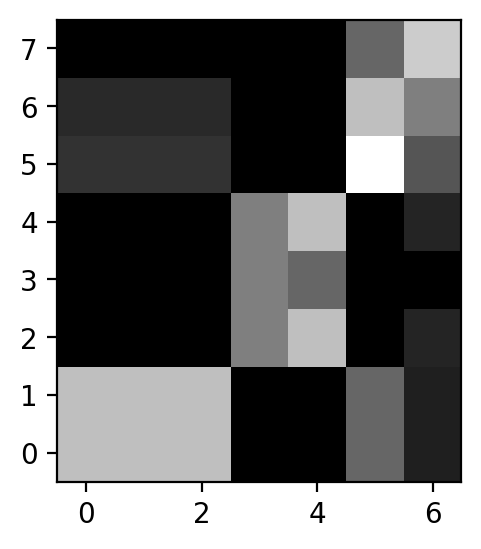

In [137]:
plt.figure(figsize=(4, 3))
plt.imshow(CM, cmap='binary', origin='lower')
plt.show()

In [139]:
ACM, warping_path = librosa.sequence.dtw(C = CM,
                                         step_sizes_sigma = np.array([[1,0], [0,1], [1,1]]))

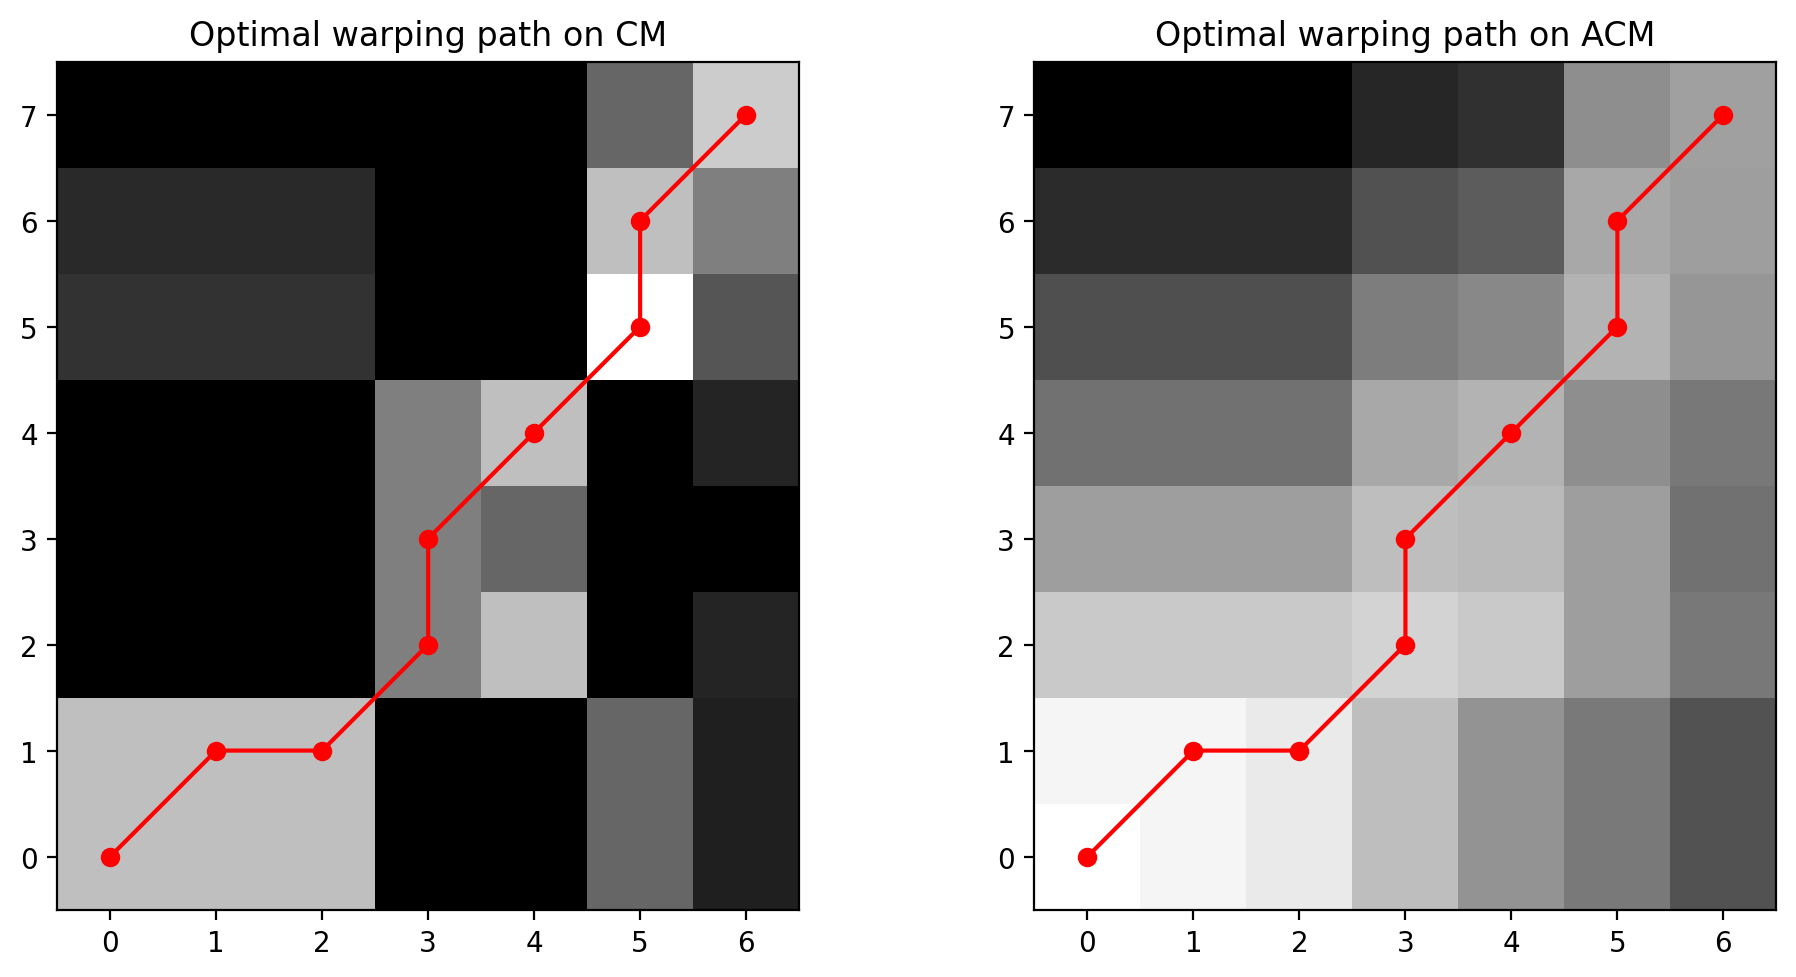

In [140]:
warping_path = np.array(warping_path) 

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(CM, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(warping_path[:, 1], warping_path[:, 0], marker='o', color='r')
#plt.clim([0, np.max(CM)])
#plt.colorbar()
plt.title('Optimal warping path on CM')

plt.subplot(1, 2, 2)
plt.imshow(ACM, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(warping_path[:, 1], warping_path[:, 0], marker='o', color='r')
#plt.clim([0, np.max(ACM)])
#plt.colorbar()
plt.title('Optimal warping path on ACM')

plt.tight_layout()